# Twitter Sentiment Analysis

### Dataset source : Sentiment140

The data is a CSV with emoticons removed. Data file format has 6 fields:  
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  
1 - the id of the tweet  
2 - the date of the tweet (ex : Sat May 16 23:58:44 UTC 2009)  
3 - the query. If there is no query, then this value is NO_QUERY.  
4 - the user that tweeted  
5 - the text of the tweet  

**Disclaimer :**  In the training set, we only use Positive or Negative scored tweets. So we make the asumption that all tweets are either positive or negative, and not neutral.

### 1/ Imports

In [1]:
# General imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Words analysis oriented imports

# Natural Language ToolKit
import nltk  
# If you uncomment, it will launch an installation popup. Go to the "Models" tab and select "punkt" from the "Identifier" column. Then click "Download" and it will install the necessary files.
#nltk.download()  
from nltk.stem import PorterStemmer # For words normalization
from sklearn.feature_extraction.text import CountVectorizer # For words frequency
from sklearn.feature_extraction.text import TfidfTransformer # For words weighting

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt

# Wordcloud
from wordcloud import WordCloud

### 2/ Read CSV

In [2]:
df = pd.read_csv("trainingandtestdata/training.1600000.processed.noemoticon.csv", header=None, encoding = "ISO-8859-1")

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 3/ Preprocessing

#### a/ Conversion into lowercase

In [3]:
cols = ['sentiment_score', 'id', 'date', 'query', 'author', 'tweet']

# Rename the columns
df.columns = cols

# Convert all tweets in lowercase
df['tweet'] = df.tweet.map(lambda x: x.lower())  

#### b/ Feature reduction - @username, urls, letter occurences, and punctuation handling

In [4]:
# Replace all the @username by the token 'USERNAME'
df.replace('\@\w+', 'USERNAME', regex=True, inplace=True)

# Replace all the urls by the token 'URL'
df.replace(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', 'URL', regex=True, inplace=True)

# Replace any letter occurring more than two times in a row with two occurrences. Ex : huuuungry becomes huungry.
# It's important to keep two occurences as they need to stay separated from the words with one occurence, because the sentiment behind a word with multiple character occurences may be stronger (positive or negative)
df.replace(r'(.)\1{2,}', r'\1\1', regex=True, inplace=True)

# Remove punctuation
df['tweet'] = df.tweet.str.replace('[^\w\s]', '') 

df.head()

,sentiment_score,id,date,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,USERNAME URL aww thats a bummer you shoulda ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,USERNAME i dived many times for the ball manag...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,USERNAME no its not behaving at all im mad why...


#### c/ Tokenization and stemming of the tweets

In [5]:
# Tokenizer
df['tweet'] = df['tweet'].apply(nltk.word_tokenize) 

# Word stemming
# Normalize our text for all variations of words carry the same meaning, regardless of the tense
stemmer = PorterStemmer()
df['tweet'] = df['tweet'].apply(lambda x: [stemmer.stem(y) for y in x]) 

df.head()

,sentiment_score,id,date,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[usernam, url, aww, that, a, bummer, you, shou..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[is, upset, that, he, cant, updat, hi, faceboo..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[usernam, i, dive, mani, time, for, the, ball,..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[my, whole, bodi, feel, itchi, and, like, it, ..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[usernam, no, it, not, behav, at, all, im, mad..."


#### d/ Words frequency calculation in the tweets and normalization of the tweets

In [6]:
# Convert the list of words into space-separated strings
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

# Transform the data into occurences
count_vect = CountVectorizer()  
counts = count_vect.fit_transform(df['tweet'])

# Use of Term Frequency Inverse Document Frequency, more known as tf-idf
# The tf–idf value increases proportionally to the number of times a word appears
transformer = TfidfTransformer().fit(counts)
counts = transformer.transform(counts)  

#### e/ Visualize the repartition of tweet polarities

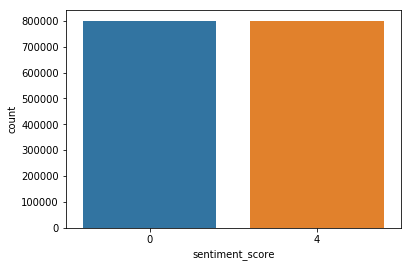

In [7]:
import seaborn as sns
sns.countplot(df['sentiment_score'],label="Count")
plt.show()

There are 800k positive tweets and 800k negative tweets. Both tweet polarities are equally represented within our dataset.

#### f/ Wordclouds of main words for both polarities

Custom colors functions

In [8]:
def orange_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [9]:
def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 170.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

**Positive words wordcloud**

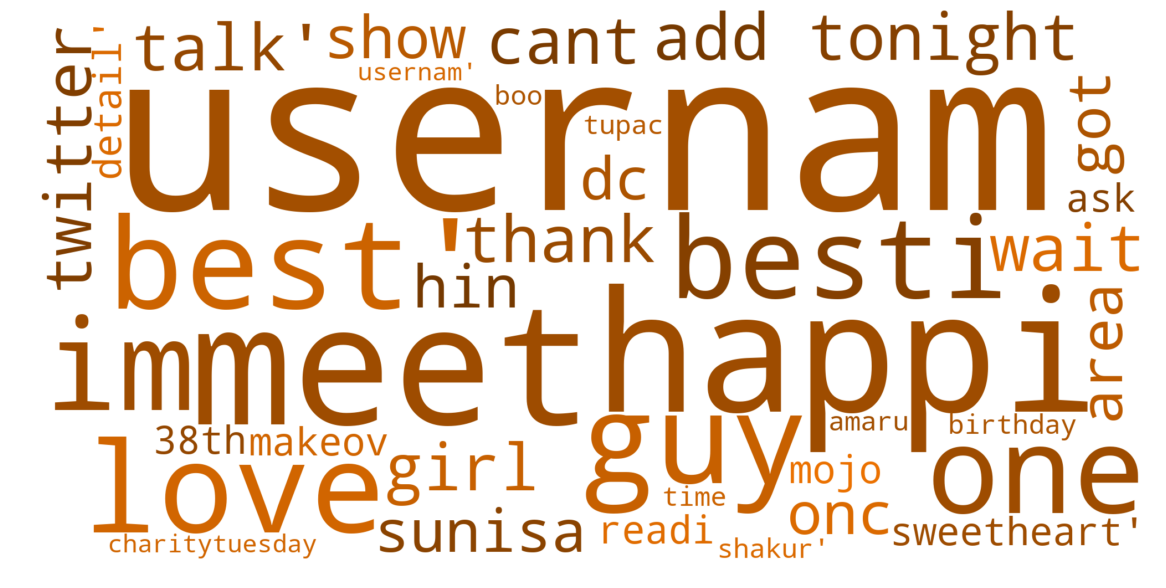

In [10]:
wordcloud = WordCloud(
    color_func = orange_color_func, 
    background_color='white',
    width=2000, 
    height=1000
).generate(str(df.loc[df['sentiment_score'] == 4]['tweet'].values))

fig = plt.figure(
    figsize=(16, 12)
)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Negative tweets wordcloud**

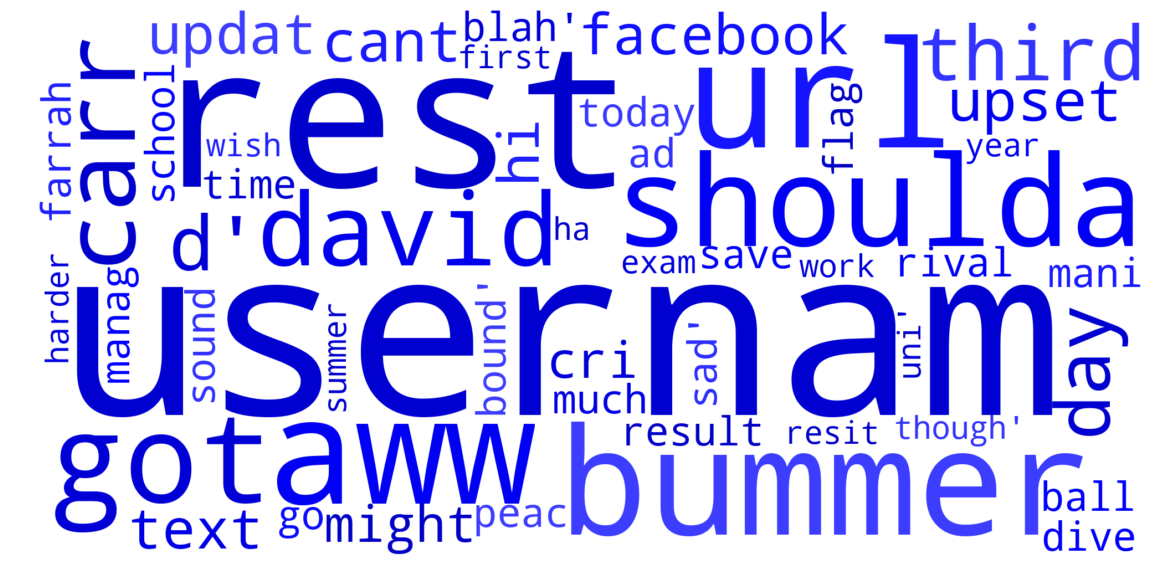

In [11]:
wordcloud = WordCloud(
    color_func = blue_color_func,
    background_color='white',
    width=2000, 
    height=1000
).generate(str(df.loc[df['sentiment_score'] == 0]['tweet'].values))

fig = plt.figure(
    figsize=(16, 12)
)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4/ Models comparison

Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(counts, df['sentiment_score'], test_size=0.2, random_state=42)  

#### a/ Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB

# For text classification problems, the Multinomial Naive Bayes Classifier is well-suited
mnb = MultinomialNB()
mnb.fit(X_train, y_train) 

print('Accuracy of NB classifier on training set: {:.2f}'
     .format(mnb.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(mnb.score(X_test, y_test)))

Accuracy of NB classifier on training set: 0.81
Accuracy of NB classifier on test set: 0.77


In [14]:
predicted = mnb.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, predicted)) 

[[125967  33527]
 [ 39963 120543]]


#### b/ SVM

SVM (Linear)

In [15]:
from sklearn.svm import LinearSVR

svm = LinearSVR()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.42
Accuracy of SVM classifier on test set: 0.35


SVM (Stochastic Gradient Descent)

In [16]:
from sklearn.linear_model import SGDClassifier


svm = SGDClassifier(max_iter=1000, tol=1e-3)
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.78
Accuracy of SVM classifier on test set: 0.78


#### c/ Logistic Regression (aka logit, MaxEnt)

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.81
Accuracy of Logistic regression classifier on test set: 0.80


### Author : Thibaut BREMAND  
- thibaut.bremand [at] gmail.com
- https://github.com/ThibautBremand

### Sources :  
- https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf : The original research paper which inspired me
- http://help.sentiment140.com  : The original training dataset  
- https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/ : Explanation of the methodology. 
- https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn : More details about the Naive Bayes classification
- https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2 : Algorithms comparison using a simple classification problem  
- https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c : Naive Bayes and Logistic Regression algorithms comparison  